### Import libraries and scripts

In [1]:
import deep_learning
import aux
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime

### Initial Data Preparation steps

Read df with each columns per each row: 24 days consumptions hourly (576 values), next day consumption cluster label, and next day hourly consumption values

In [2]:
import time 

colnames_ = ["consumer_id","day_id"]
w_list = ['w' + str(x) for x in range(0,576)]
colnames_.extend(w_list)
colnames_.append("next_day_cluster")
d_list = ['d' + str(x) for x in range(0,24)]
colnames_.extend(d_list)
s_time_dask = time.time()
#data = pd.read_csv ("../data/todos_24diasprevios.csv",sep=";",header=None, names=colnames_)
data = pd.read_csv("../data/loads_535_2.csv",sep=";",header=None, names=colnames_)
#df_chunk = pd.read_csv("../data/todos_24diasprevios.csv",sep=";",header=None, names=colnames_, chunksize=100000)
e_time_dask = time.time()
print("Read time: ", (e_time_dask-s_time_dask), "seconds")

Read time:  5.375431299209595 seconds


In [3]:
data

,consumer_id,day_id,w0,w1,w2,w3,w4,w5,w6,w7,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
0,2586,218,989,673,625,419,168,153,153,141,...,749,658,1251,636,2121,529,487,506,581,631
1,2586,219,1000,1158,610,530,416,580,483,206,...,825,290,576,2354,3895,1925,1761,728,578,598
2,2586,220,842,273,161,160,152,147,322,270,...,1952,4172,1164,385,834,781,673,1173,660,576
3,2586,221,472,1559,498,427,167,142,160,162,...,256,1009,2643,4493,5230,9892,4106,3004,1386,1336
4,2586,222,993,919,378,358,390,208,161,147,...,364,237,2378,2362,1364,1033,566,708,822,709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204793,3910,725,65,187,98,46,81,215,46,249,...,46,220,95,45,185,510,1254,1097,771,769
204794,3910,726,201,104,46,246,48,503,433,49,...,393,476,444,709,1620,951,615,1162,375,403
204795,3910,727,81,118,174,46,107,183,46,46,...,94,124,969,2750,198,511,566,427,453,139
204796,3910,728,399,46,59,226,311,55,221,66,...,872,2401,1877,491,502,307,667,351,454,2034


### split  data consumptions by user using dictionaries (id consumer_id)

In [6]:
## using pandas read_csv (not big dataset)
dfs = dict(tuple(data.groupby('consumer_id')))

In [7]:
dfs

{2586:      consumer_id  day_id    w0    w1   w2   w3   w4   w5   w6    w7  ...  \
 0           2586     218   989   673  625  419  168  153  153   141  ...   
 1           2586     219  1000  1158  610  530  416  580  483   206  ...   
 2           2586     220   842   273  161  160  152  147  322   270  ...   
 3           2586     221   472  1559  498  427  167  142  160   162  ...   
 4           2586     222   993   919  378  358  390  208  161   147  ...   
 ..           ...     ...   ...   ...  ...  ...  ...  ...  ...   ...  ...   
 507         2586     725   214   168  203  164  208  283  462   900  ...   
 508         2586     726   816   603  280  159  159  159  143   214  ...   
 509         2586     727  1180   753  615  386  250  243  242   312  ...   
 510         2586     728   661   321  303  253  300  282  401   533  ...   
 511         2586     729   389   375  347  342  346  352  482  2507  ...   
 
       d14   d15   d16   d17   d18   d19   d20   d21   d22   d23  
 

### Remove last 23 rows (group_resized) for each user  and prepare day slide windows (slide_windows) for each user

In [8]:
from numpy.lib.stride_tricks import sliding_window_view

#slide_windows_= []
groups_resized = []

slide_windows_dictionary = dict()

for key,value in dfs.items():
    
    id_user = key
    val = value
     
    slide_windows = sliding_window_view(val.day_id, 24)
    
    slide_windows_dictionary[id_user] = slide_windows
     
    groups_resized.append(value[:-23])


In [9]:
groups_resized

[     consumer_id  day_id    w0    w1   w2   w3   w4   w5   w6    w7  ...  \
 0           2586     218   989   673  625  419  168  153  153   141  ...   
 1           2586     219  1000  1158  610  530  416  580  483   206  ...   
 2           2586     220   842   273  161  160  152  147  322   270  ...   
 3           2586     221   472  1559  498  427  167  142  160   162  ...   
 4           2586     222   993   919  378  358  390  208  161   147  ...   
 ..           ...     ...   ...   ...  ...  ...  ...  ...  ...   ...  ...   
 484         2586     702   450   274  249  266  243  251  460  2530  ...   
 485         2586     703   230   211  175  188  185  210  314  2838  ...   
 486         2586     704   311   211  195  201  171  186  313  2086  ...   
 487         2586     705   980   782  199  166  185  181  189   195  ...   
 488         2586     706  1066   912  339  237  213  200  194   152  ...   
 
       d14   d15   d16   d17   d18   d19   d20   d21   d22   d23  
 0     

In [15]:
groups_resized[len(groups_resized)-1]

,consumer_id,day_id,w0,w1,w2,w3,w4,w5,w6,w7,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
204286,3910,218,900,201,78,275,164,166,218,238,...,1144,555,242,396,344,324,205,856,581,424
204287,3910,219,327,167,68,277,115,545,193,479,...,1721,1560,252,287,388,1641,1967,756,578,667
204288,3910,220,290,121,153,234,64,232,143,114,...,64,217,123,152,175,89,224,45,717,891
204289,3910,221,243,173,74,277,108,141,247,66,...,140,169,207,62,251,57,222,1990,1235,805
204290,3910,222,230,244,64,217,160,67,277,282,...,388,499,120,811,3136,427,186,734,834,737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204770,3910,702,166,147,46,221,81,45,243,570,...,649,2423,267,662,527,426,1534,315,348,528
204771,3910,703,54,260,60,94,228,320,118,438,...,311,2641,348,589,517,512,1778,830,553,471
204772,3910,704,256,83,61,258,49,89,222,203,...,614,1322,538,663,561,574,1738,468,202,492
204773,3910,705,138,229,84,46,249,62,302,237,...,831,499,463,545,598,1850,705,314,412,649


In [10]:
slide_windows_dictionary

{2586: array([[218, 219, 220, ..., 239, 240, 241],
        [219, 220, 221, ..., 240, 241, 242],
        [220, 221, 222, ..., 241, 242, 243],
        ...,
        [704, 705, 706, ..., 725, 726, 727],
        [705, 706, 707, ..., 726, 727, 728],
        [706, 707, 708, ..., 727, 728, 729]]),
 2590: array([[218, 219, 220, ..., 239, 240, 241],
        [219, 220, 221, ..., 240, 241, 242],
        [220, 221, 222, ..., 241, 242, 243],
        ...,
        [704, 705, 706, ..., 725, 726, 727],
        [705, 706, 707, ..., 726, 727, 728],
        [706, 707, 708, ..., 727, 728, 729]]),
 2594: array([[218, 219, 220, ..., 239, 240, 241],
        [219, 220, 221, ..., 240, 241, 242],
        [220, 221, 222, ..., 241, 242, 243],
        ...,
        [704, 705, 706, ..., 725, 726, 727],
        [705, 706, 707, ..., 726, 727, 728],
        [706, 707, 708, ..., 727, 728, 729]]),
 2595: array([[218, 219, 220, ..., 239, 240, 241],
        [219, 220, 221, ..., 240, 241, 242],
        [220, 221, 222, ..., 24

In [13]:
# slide windows day example for consumer 3910
slide_windows_dictionary[3910]

array([[218, 219, 220, ..., 239, 240, 241],
       [219, 220, 221, ..., 240, 241, 242],
       [220, 221, 222, ..., 241, 242, 243],
       ...,
       [704, 705, 706, ..., 725, 726, 727],
       [705, 706, 707, ..., 726, 727, 728],
       [706, 707, 708, ..., 727, 728, 729]])

Once the 23 days per user have been eliminated (which allows us to prepare the sliding window of days) and the sliding window has been prepared, we merge the consumption data of all consumers in a dataframe.

In [16]:
consumption_full_df = pd.concat(groups_resized)
consumption_full_df

,consumer_id,day_id,w0,w1,w2,w3,w4,w5,w6,w7,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
0,2586,218,989,673,625,419,168,153,153,141,...,749,658,1251,636,2121,529,487,506,581,631
1,2586,219,1000,1158,610,530,416,580,483,206,...,825,290,576,2354,3895,1925,1761,728,578,598
2,2586,220,842,273,161,160,152,147,322,270,...,1952,4172,1164,385,834,781,673,1173,660,576
3,2586,221,472,1559,498,427,167,142,160,162,...,256,1009,2643,4493,5230,9892,4106,3004,1386,1336
4,2586,222,993,919,378,358,390,208,161,147,...,364,237,2378,2362,1364,1033,566,708,822,709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204770,3910,702,166,147,46,221,81,45,243,570,...,649,2423,267,662,527,426,1534,315,348,528
204771,3910,703,54,260,60,94,228,320,118,438,...,311,2641,348,589,517,512,1778,830,553,471
204772,3910,704,256,83,61,258,49,89,222,203,...,614,1322,538,663,561,574,1738,468,202,492
204773,3910,705,138,229,84,46,249,62,302,237,...,831,499,463,545,598,1850,705,314,412,649


In [17]:
## create list with 24 days
names = []
for i in range(24):
    names.append("d"+str(i))
names

['d0',
 'd1',
 'd2',
 'd3',
 'd4',
 'd5',
 'd6',
 'd7',
 'd8',
 'd9',
 'd10',
 'd11',
 'd12',
 'd13',
 'd14',
 'd15',
 'd16',
 'd17',
 'd18',
 'd19',
 'd20',
 'd21',
 'd22',
 'd23']

### Data splitting (train, validation and test)

get user ids on each set (train, test, val)

In [18]:
from sklearn.model_selection import train_test_split

consumers_ids = data.consumer_id.unique()

consumers_train, consumers_test = train_test_split(consumers_ids, test_size=0.1, random_state=1)

consumers_train, consumers_val = train_test_split(consumers_train, test_size=0.20, random_state=1)


In [19]:
len(consumers_train)

288

In [20]:
len(consumers_val)

72

In [21]:
len(consumers_test)

40

### train, test and val dataset for splitted set users

In [58]:
train_ds = consumption_full_df[consumption_full_df.consumer_id.isin(consumers_train)]
train_ds

,consumer_id,day_id,w0,w1,w2,w3,w4,w5,w6,w7,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
512,2590,218,383,275,287,240,284,237,276,269,...,1032,1238,773,943,2615,1386,1935,1209,1277,1246
513,2590,219,1061,831,261,299,257,306,291,277,...,959,1713,2128,1641,454,804,507,2058,1381,1151
514,2590,220,590,284,253,257,286,3027,513,190,...,466,231,829,551,309,261,215,1247,1120,1284
515,2590,221,215,159,216,165,216,199,190,212,...,582,696,440,373,905,2987,1334,656,805,744
516,2590,222,218,183,195,215,200,216,160,219,...,964,950,539,2337,1532,697,625,835,1325,1558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202722,3897,702,1877,1867,1870,1836,1817,1812,1858,1836,...,2455,2479,2462,2456,2425,2463,2458,2459,2438,2424
202723,3897,703,2526,2495,2501,2489,2465,2442,2470,2447,...,2481,2462,2403,2455,2456,2428,2456,2454,2407,2456
202724,3897,704,2504,2514,2469,2449,2445,2470,2454,2452,...,7039,7122,7153,7255,6774,6579,6408,2507,2463,2433
202725,3897,705,2221,2234,2193,2181,2209,2177,2174,2192,...,3858,3876,4756,5274,2479,2442,2475,2481,2460,2478


In [59]:
val_ds = consumption_full_df[consumption_full_df.consumer_id.isin(consumers_val)]
val_ds

,consumer_id,day_id,w0,w1,w2,w3,w4,w5,w6,w7,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
0,2586,218,989,673,625,419,168,153,153,141,...,749,658,1251,636,2121,529,487,506,581,631
1,2586,219,1000,1158,610,530,416,580,483,206,...,825,290,576,2354,3895,1925,1761,728,578,598
2,2586,220,842,273,161,160,152,147,322,270,...,1952,4172,1164,385,834,781,673,1173,660,576
3,2586,221,472,1559,498,427,167,142,160,162,...,256,1009,2643,4493,5230,9892,4106,3004,1386,1336
4,2586,222,993,919,378,358,390,208,161,147,...,364,237,2378,2362,1364,1033,566,708,822,709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204770,3910,702,166,147,46,221,81,45,243,570,...,649,2423,267,662,527,426,1534,315,348,528
204771,3910,703,54,260,60,94,228,320,118,438,...,311,2641,348,589,517,512,1778,830,553,471
204772,3910,704,256,83,61,258,49,89,222,203,...,614,1322,538,663,561,574,1738,468,202,492
204773,3910,705,138,229,84,46,249,62,302,237,...,831,499,463,545,598,1850,705,314,412,649


In [60]:
test_ds = consumption_full_df[consumption_full_df.consumer_id.isin(consumers_test)]
test_ds

,consumer_id,day_id,w0,w1,w2,w3,w4,w5,w6,w7,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
2048,2598,218,305,243,242,239,216,222,246,244,...,393,464,460,482,869,419,243,321,421,459
2049,2598,219,353,232,232,233,232,232,232,218,...,414,725,934,477,570,269,243,1053,486,477
2050,2598,220,356,718,592,228,788,236,238,645,...,597,574,510,463,476,603,242,460,470,372
2051,2598,221,390,272,241,223,220,242,264,298,...,376,477,406,394,587,532,512,505,509,494
2052,2598,222,351,255,248,233,225,243,249,244,...,557,449,501,520,462,612,512,513,506,395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204258,3904,702,1917,2703,2931,2813,1922,1581,2593,1134,...,1069,678,723,1828,1509,1139,1066,1001,535,567
204259,3904,703,360,519,364,286,383,531,499,984,...,606,356,1148,1685,1570,4738,5552,4971,1374,353
204260,3904,704,1009,345,189,258,361,261,607,1027,...,773,1392,3334,6424,3373,1785,2795,4838,4437,1211
204261,3904,705,240,263,299,324,256,421,689,999,...,589,1297,2555,1712,2229,1137,1108,1013,536,1876


### Get only 365 first days (train and val) and rest of days for test (future predictions)

In [61]:
train_ds = train_ds.groupby("consumer_id").head(365)

In [62]:
train_ds

,consumer_id,day_id,w0,w1,w2,w3,w4,w5,w6,w7,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
512,2590,218,383,275,287,240,284,237,276,269,...,1032,1238,773,943,2615,1386,1935,1209,1277,1246
513,2590,219,1061,831,261,299,257,306,291,277,...,959,1713,2128,1641,454,804,507,2058,1381,1151
514,2590,220,590,284,253,257,286,3027,513,190,...,466,231,829,551,309,261,215,1247,1120,1284
515,2590,221,215,159,216,165,216,199,190,212,...,582,696,440,373,905,2987,1334,656,805,744
516,2590,222,218,183,195,215,200,216,160,219,...,964,950,539,2337,1532,697,625,835,1325,1558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202598,3897,578,2366,2342,2316,2366,2310,2351,2341,2339,...,2596,2571,2636,2577,2615,2613,2599,2591,2620,2574
202599,3897,579,2384,2321,2338,2348,2330,2357,2505,2339,...,3359,4398,5053,5093,4262,2579,2601,2619,2580,2605
202600,3897,580,2357,2318,2298,2355,2299,2318,2333,2341,...,5926,5956,5968,5983,5992,3293,2616,2577,2571,2632
202601,3897,581,2321,2301,2357,2313,2306,2360,2298,2321,...,2647,2610,2635,2634,2649,3674,4835,2646,2637,2607


In [63]:
val_ds = val_ds.groupby("consumer_id").head(365)
val_ds

,consumer_id,day_id,w0,w1,w2,w3,w4,w5,w6,w7,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
0,2586,218,989,673,625,419,168,153,153,141,...,749,658,1251,636,2121,529,487,506,581,631
1,2586,219,1000,1158,610,530,416,580,483,206,...,825,290,576,2354,3895,1925,1761,728,578,598
2,2586,220,842,273,161,160,152,147,322,270,...,1952,4172,1164,385,834,781,673,1173,660,576
3,2586,221,472,1559,498,427,167,142,160,162,...,256,1009,2643,4493,5230,9892,4106,3004,1386,1336
4,2586,222,993,919,378,358,390,208,161,147,...,364,237,2378,2362,1364,1033,566,708,822,709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204646,3910,578,617,705,232,249,107,320,414,151,...,255,409,354,1961,1502,586,245,455,556,359
204647,3910,579,374,437,174,67,256,87,164,328,...,150,2956,227,448,508,177,1551,295,319,366
204648,3910,580,63,231,185,46,234,131,64,253,...,1249,352,172,380,249,276,2048,298,230,392
204649,3910,581,127,141,195,46,256,74,173,309,...,1529,239,130,401,387,1042,2020,1228,444,317


In [64]:
test_ds = test_ds.drop(test_ds.groupby("consumer_id").head(365).index, axis=0)
test_ds

,consumer_id,day_id,w0,w1,w2,w3,w4,w5,w6,w7,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
2413,2598,583,383,378,349,321,313,514,344,323,...,657,792,6677,1496,1933,2031,488,1779,523,407
2414,2598,584,1465,762,873,380,936,356,645,738,...,409,406,817,454,972,7169,2004,2230,696,463
2415,2598,585,3474,697,355,632,813,558,296,292,...,6262,1948,1638,996,790,418,449,603,499,457
2416,2598,586,392,387,384,386,327,308,253,225,...,303,358,1383,1075,317,422,346,833,519,893
2417,2598,587,467,356,334,325,331,359,740,556,...,481,489,431,539,653,466,1861,1951,600,4351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204258,3904,702,1917,2703,2931,2813,1922,1581,2593,1134,...,1069,678,723,1828,1509,1139,1066,1001,535,567
204259,3904,703,360,519,364,286,383,531,499,984,...,606,356,1148,1685,1570,4738,5552,4971,1374,353
204260,3904,704,1009,345,189,258,361,261,607,1027,...,773,1392,3334,6424,3373,1785,2795,4838,4437,1211
204261,3904,705,240,263,299,324,256,421,689,999,...,589,1297,2555,1712,2229,1137,1108,1013,536,1876


### Day of week and day of year data preparation
### falta seleccionar 365 días primeros de cada ventana deslizante!!!!!!!

In [120]:
dict_train = {key: slide_windows_dictionary[key] for key in consumers_train}
dict_val = {key: slide_windows_dictionary[key] for key in consumers_val}
dict_test = {key: slide_windows_dictionary[key] for key in consumers_test}

In [185]:
names = []
for i in range(24):
    names.append("d"+str(i))
    
#slide train
slide_train = [d[1] for d in dict_train.items()]

first_365_list = []
for c in slide_train:
    first365 = c[:365]
    first_365_list.append(first365)

slide_train_df = pd.DataFrame(np.concatenate(first_365_list), columns = names) 

#slide val
slide_val = [d[1] for d in dict_val.items()]

first_365_list = []
for c in slide_val:
    first365 = c[:365]
    first_365_list.append(first365)
    
slide_val_df = pd.DataFrame(np.concatenate(first_365_list), columns = names) 


#slide test
slide_test = [d[1] for d in dict_test.items()]

first_365_list = []
for c in slide_test:
    first365 = c[365:len(c)]
    first_365_list.append(first365)

slide_test_df = pd.DataFrame(np.concatenate(first_365_list), columns = names) 


In [186]:
slide_test_df

,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
0,583,584,585,586,587,588,589,590,591,592,...,597,598,599,600,601,602,603,604,605,606
1,584,585,586,587,588,589,590,591,592,593,...,598,599,600,601,602,603,604,605,606,607
2,585,586,587,588,589,590,591,592,593,594,...,599,600,601,602,603,604,605,606,607,608
3,586,587,588,589,590,591,592,593,594,595,...,600,601,602,603,604,605,606,607,608,609
4,587,588,589,590,591,592,593,594,595,596,...,601,602,603,604,605,606,607,608,609,610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4955,702,703,704,705,706,707,708,709,710,711,...,716,717,718,719,720,721,722,723,724,725
4956,703,704,705,706,707,708,709,710,711,712,...,717,718,719,720,721,722,723,724,725,726
4957,704,705,706,707,708,709,710,711,712,713,...,718,719,720,721,722,723,724,725,726,727
4958,705,706,707,708,709,710,711,712,713,714,...,719,720,721,722,723,724,725,726,727,728


In [187]:
test_ds

,consumer_id,day_id,w0,w1,w2,w3,w4,w5,w6,w7,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
2413,2598,583,383,378,349,321,313,514,344,323,...,657,792,6677,1496,1933,2031,488,1779,523,407
2414,2598,584,1465,762,873,380,936,356,645,738,...,409,406,817,454,972,7169,2004,2230,696,463
2415,2598,585,3474,697,355,632,813,558,296,292,...,6262,1948,1638,996,790,418,449,603,499,457
2416,2598,586,392,387,384,386,327,308,253,225,...,303,358,1383,1075,317,422,346,833,519,893
2417,2598,587,467,356,334,325,331,359,740,556,...,481,489,431,539,653,466,1861,1951,600,4351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204258,3904,702,1917,2703,2931,2813,1922,1581,2593,1134,...,1069,678,723,1828,1509,1139,1066,1001,535,567
204259,3904,703,360,519,364,286,383,531,499,984,...,606,356,1148,1685,1570,4738,5552,4971,1374,353
204260,3904,704,1009,345,189,258,361,261,607,1027,...,773,1392,3334,6424,3373,1785,2795,4838,4437,1211
204261,3904,705,240,263,299,324,256,421,689,999,...,589,1297,2555,1712,2229,1137,1108,1013,536,1876


Calculation of first day (stard data time) of dataset

In [188]:
from datetime import datetime
origin_date = datetime(2009, 1, 1) 

In [189]:
origin_date

datetime.datetime(2009, 1, 1, 0, 0)

In [190]:
## return day of year for day_id
def get_day_of_year_for_consumption_day(x):
    day = (origin_date + pd.to_timedelta(x,unit="days"))
    return day.dt.dayofyear

In [191]:
## return day of month for day_id
def get_day_of_week_for_consumption_day(x):
    day = origin_date + pd.to_timedelta(x,unit="days")
    return day.dt.weekday

Prepara datasets with day of year and day of week for train, test and val

In [192]:
day_of_year_for_consumption_days_train = slide_train_df.apply( 
    get_day_of_year_for_consumption_day )

day_of_year_for_consumption_days_val = slide_val_df.apply( 
    get_day_of_year_for_consumption_day )

day_of_year_for_consumption_days_test = slide_test_df.apply( 
    get_day_of_year_for_consumption_day )

days_for_consumption_days_train = slide_train_df.apply( 
    get_day_of_week_for_consumption_day )

days_for_consumption_days_val = slide_val_df.apply( 
    get_day_of_week_for_consumption_day )

days_for_consumption_days_test = slide_test_df.apply( 
    get_day_of_week_for_consumption_day )




In [193]:
day_of_year_for_consumption_days_train

,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
0,219,220,221,222,223,224,225,226,227,228,...,233,234,235,236,237,238,239,240,241,242
1,220,221,222,223,224,225,226,227,228,229,...,234,235,236,237,238,239,240,241,242,243
2,221,222,223,224,225,226,227,228,229,230,...,235,236,237,238,239,240,241,242,243,244
3,222,223,224,225,226,227,228,229,230,231,...,236,237,238,239,240,241,242,243,244,245
4,223,224,225,226,227,228,229,230,231,232,...,237,238,239,240,241,242,243,244,245,246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105115,214,215,216,217,218,219,220,221,222,223,...,228,229,230,231,232,233,234,235,236,237
105116,215,216,217,218,219,220,221,222,223,224,...,229,230,231,232,233,234,235,236,237,238
105117,216,217,218,219,220,221,222,223,224,225,...,230,231,232,233,234,235,236,237,238,239
105118,217,218,219,220,221,222,223,224,225,226,...,231,232,233,234,235,236,237,238,239,240


In [194]:
days_for_consumption_days_train

,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
0,4,5,6,0,1,2,3,4,5,6,...,4,5,6,0,1,2,3,4,5,6
1,5,6,0,1,2,3,4,5,6,0,...,5,6,0,1,2,3,4,5,6,0
2,6,0,1,2,3,4,5,6,0,1,...,6,0,1,2,3,4,5,6,0,1
3,0,1,2,3,4,5,6,0,1,2,...,0,1,2,3,4,5,6,0,1,2
4,1,2,3,4,5,6,0,1,2,3,...,1,2,3,4,5,6,0,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105115,0,1,2,3,4,5,6,0,1,2,...,0,1,2,3,4,5,6,0,1,2
105116,1,2,3,4,5,6,0,1,2,3,...,1,2,3,4,5,6,0,1,2,3
105117,2,3,4,5,6,0,1,2,3,4,...,2,3,4,5,6,0,1,2,3,4
105118,3,4,5,6,0,1,2,3,4,5,...,3,4,5,6,0,1,2,3,4,5


In [195]:
### to-do for cyclic days of year 
def filter_day_of_year(x):
    if x==182 | x==183 | x==184:
        return 182
    if x>184:
        return abs(365-x)+1
    else: 
        return x

In [196]:
days = []
for i in range(24):
    days.append("d"+str(i))

In [197]:
for i in range(24):
    day_of_year_for_consumption_days_train[days[i]]= day_of_year_for_consumption_days_train[days[i]].apply(filter_day_of_year)

day_of_year_for_consumption_days_train

,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
0,147,146,145,144,143,142,141,140,139,138,...,133,132,131,130,129,128,127,126,125,124
1,146,145,144,143,142,141,140,139,138,137,...,132,131,130,129,128,127,126,125,124,123
2,145,144,143,142,141,140,139,138,137,136,...,131,130,129,128,127,126,125,124,123,122
3,144,143,142,141,140,139,138,137,136,135,...,130,129,128,127,126,125,124,123,122,121
4,143,142,141,140,139,138,137,136,135,134,...,129,128,127,126,125,124,123,122,121,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105115,152,151,150,149,148,147,146,145,144,143,...,138,137,136,135,134,133,132,131,130,129
105116,151,150,149,148,147,146,145,144,143,142,...,137,136,135,134,133,132,131,130,129,128
105117,150,149,148,147,146,145,144,143,142,141,...,136,135,134,133,132,131,130,129,128,127
105118,149,148,147,146,145,144,143,142,141,140,...,135,134,133,132,131,130,129,128,127,126


In [198]:
for i in range(24):
    day_of_year_for_consumption_days_val[days[i]]= day_of_year_for_consumption_days_val[days[i]].apply(filter_day_of_year)

day_of_year_for_consumption_days_val

,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
0,147,146,145,144,143,142,141,140,139,138,...,133,132,131,130,129,128,127,126,125,124
1,146,145,144,143,142,141,140,139,138,137,...,132,131,130,129,128,127,126,125,124,123
2,145,144,143,142,141,140,139,138,137,136,...,131,130,129,128,127,126,125,124,123,122
3,144,143,142,141,140,139,138,137,136,135,...,130,129,128,127,126,125,124,123,122,121
4,143,142,141,140,139,138,137,136,135,134,...,129,128,127,126,125,124,123,122,121,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26275,152,151,150,149,148,147,146,145,144,143,...,138,137,136,135,134,133,132,131,130,129
26276,151,150,149,148,147,146,145,144,143,142,...,137,136,135,134,133,132,131,130,129,128
26277,150,149,148,147,146,145,144,143,142,141,...,136,135,134,133,132,131,130,129,128,127
26278,149,148,147,146,145,144,143,142,141,140,...,135,134,133,132,131,130,129,128,127,126


In [199]:
for i in range(24):
    day_of_year_for_consumption_days_test[days[i]]= day_of_year_for_consumption_days_test[days[i]].apply(filter_day_of_year)

day_of_year_for_consumption_days_test

,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
0,147,146,145,144,143,142,141,140,139,138,...,133,132,131,130,129,128,127,126,125,124
1,146,145,144,143,142,141,140,139,138,137,...,132,131,130,129,128,127,126,125,124,123
2,145,144,143,142,141,140,139,138,137,136,...,131,130,129,128,127,126,125,124,123,122
3,144,143,142,141,140,139,138,137,136,135,...,130,129,128,127,126,125,124,123,122,121
4,143,142,141,140,139,138,137,136,135,134,...,129,128,127,126,125,124,123,122,121,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4955,28,27,26,25,24,23,22,21,20,19,...,14,13,12,11,10,9,8,7,6,5
4956,27,26,25,24,23,22,21,20,19,18,...,13,12,11,10,9,8,7,6,5,4
4957,26,25,24,23,22,21,20,19,18,17,...,12,11,10,9,8,7,6,5,4,3
4958,25,24,23,22,21,20,19,18,17,16,...,11,10,9,8,7,6,5,4,3,2


### Prepare consumptions and next day consumptions datasets for train, test and val (6)

In [200]:

data_consumptions_train = train_ds.iloc[:,2:] 
data_consumptions_nexd_day_train = data_consumptions_train.iloc[:,577:602]
data_consumptions_train = data_consumptions_train.iloc[: , :-25]

data_consumptions_val = val_ds.iloc[:,2:] 
data_consumptions_nexd_day_val = data_consumptions_val.iloc[:,577:602]
data_consumptions_val = data_consumptions_val.iloc[: , :-25]

data_consumptions_test = test_ds.iloc[:,2:] 
data_consumptions_nexd_day_test = data_consumptions_test.iloc[:,577:602]
data_consumptions_test = data_consumptions_test.iloc[: , :-25]


In [201]:
data_consumptions_nexd_day_train

,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
512,1204,735,362,278,269,299,240,289,243,507,...,1032,1238,773,943,2615,1386,1935,1209,1277,1246
513,1027,485,466,300,259,297,233,286,252,2787,...,959,1713,2128,1641,454,804,507,2058,1381,1151
514,905,934,377,455,304,251,275,312,234,549,...,466,231,829,551,309,261,215,1247,1120,1284
515,1516,1171,361,261,293,284,230,278,237,1334,...,582,696,440,373,905,2987,1334,656,805,744
516,959,314,228,270,264,245,290,245,270,267,...,964,950,539,2337,1532,697,625,835,1325,1558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202598,2608,2571,2630,2576,2598,2617,2574,2596,2612,2604,...,2596,2571,2636,2577,2615,2613,2599,2591,2620,2574
202599,2650,2600,2583,2637,2577,2602,2604,2594,2569,2931,...,3359,4398,5053,5093,4262,2579,2601,2619,2580,2605
202600,2608,2647,2584,2598,2605,2584,2596,2730,5453,6057,...,5926,5956,5968,5983,5992,3293,2616,2577,2571,2632
202601,2596,2614,2582,2614,2594,2579,2609,2596,2578,2593,...,2647,2610,2635,2634,2649,3674,4835,2646,2637,2607


In [202]:
data_consumptions_train

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,...,w566,w567,w568,w569,w570,w571,w572,w573,w574,w575
512,383,275,287,240,284,237,276,269,2080,677,...,515,516,555,571,3197,1845,713,2266,3828,1543
513,1061,831,261,299,257,306,291,277,3046,6104,...,1032,1238,773,943,2615,1386,1935,1209,1277,1246
514,590,284,253,257,286,3027,513,190,205,203,...,959,1713,2128,1641,454,804,507,2058,1381,1151
515,215,159,216,165,216,199,190,212,163,216,...,466,231,829,551,309,261,215,1247,1120,1284
516,218,183,195,215,200,216,160,219,366,192,...,582,696,440,373,905,2987,1334,656,805,744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202598,2366,2342,2316,2366,2310,2351,2341,2339,2360,2302,...,2571,2639,2576,2606,2609,2600,2600,2618,2574,2602
202599,2384,2321,2338,2348,2330,2357,2505,2339,2343,2322,...,2596,2571,2636,2577,2615,2613,2599,2591,2620,2574
202600,2357,2318,2298,2355,2299,2318,2333,2341,2306,2392,...,3359,4398,5053,5093,4262,2579,2601,2619,2580,2605
202601,2321,2301,2357,2313,2306,2360,2298,2321,2947,5160,...,5926,5956,5968,5983,5992,3293,2616,2577,2571,2632


# Image generation

- example one image

In [203]:
dow_first_row = days_for_consumption_days_train.iloc[0].to_numpy()
dow_img = dow_first_row
for i in range (0,23):
    dow_img = np.column_stack((dow_img,dow_first_row))
dow_img

array([[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4],
       [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5],
       [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4],
       [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5],
       [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [1, 1, 1, 1, 1

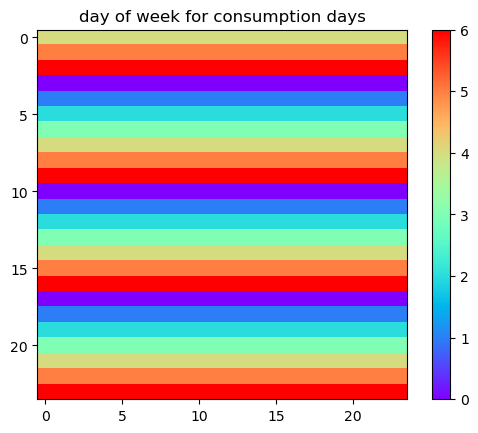

In [204]:
plt.imshow(dow_img,cmap = 'rainbow')
plt.title("day of week for consumption days")
plt.colorbar()

In [205]:
month_first_row = day_of_year_for_consumption_days_train.iloc[0].to_numpy()
month_img = month_first_row
for i in range (0,23):
    month_img = np.column_stack((month_img,month_first_row))
month_img

array([[147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147,
        147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147],
       [146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146,
        146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146],
       [145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145,
        145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145],
       [144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144,
        144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144],
       [143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143,
        143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143],
       [142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
        142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142],
       [141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141,
        141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141],
       [140, 140, 140, 140, 140, 140, 140

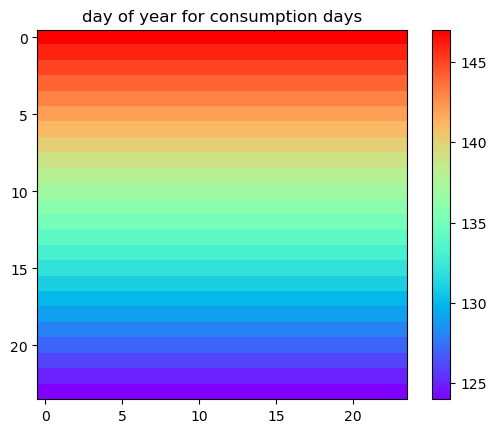

In [206]:
plt.imshow(month_img,cmap = 'rainbow')
plt.title("day of year for consumption days")
plt.colorbar()

### Normalize consumptions datasets

In [207]:
max_val = data.drop(['next_day_cluster','day_id','consumer_id'], axis=1).to_numpy().max()
min_val = data.drop(['next_day_cluster','day_id','consumer_id'], axis=1).to_numpy().min()
max_val

14916

In [208]:
def normalize_row(x):
    normalized = (x - min_val) / (max_val - min_val)
    return normalized


In [209]:
data_consumptions_train = data_consumptions_train.apply(
    normalize_row,
    axis=1)
data_consumptions_train

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,...,w566,w567,w568,w569,w570,w571,w572,w573,w574,w575
512,0.025612,0.018371,0.019175,0.016024,0.018974,0.015823,0.018438,0.017968,0.139390,0.045323,...,0.034462,0.034529,0.037144,0.038217,0.214281,0.123634,0.047737,0.151861,0.256587,0.103386
513,0.071069,0.055649,0.017432,0.019980,0.017164,0.020449,0.019444,0.018505,0.204157,0.409185,...,0.069125,0.082937,0.051760,0.063158,0.175260,0.092860,0.129668,0.080992,0.085551,0.083473
514,0.039490,0.018974,0.016896,0.017164,0.019108,0.202883,0.034328,0.012672,0.013678,0.013543,...,0.064231,0.114784,0.142608,0.109956,0.030372,0.053838,0.033926,0.137915,0.092524,0.077104
515,0.014348,0.010593,0.014415,0.010996,0.014415,0.013275,0.012672,0.014147,0.010862,0.014415,...,0.031177,0.015421,0.055515,0.036876,0.020650,0.017432,0.014348,0.083540,0.075025,0.086021
516,0.014549,0.012202,0.013007,0.014348,0.013342,0.014415,0.010660,0.014616,0.024472,0.012806,...,0.038954,0.046597,0.029433,0.024941,0.060610,0.200201,0.089373,0.043916,0.053905,0.049816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202598,0.158565,0.156956,0.155213,0.158565,0.154811,0.157560,0.156889,0.156755,0.158163,0.154274,...,0.172310,0.176869,0.172645,0.174656,0.174858,0.174254,0.174254,0.175461,0.172511,0.174388
202599,0.159772,0.155548,0.156688,0.157358,0.156152,0.157962,0.167885,0.156755,0.157023,0.155615,...,0.173986,0.172310,0.176668,0.172712,0.175260,0.175126,0.174187,0.173651,0.175595,0.172511
202600,0.157962,0.155347,0.154006,0.157828,0.154073,0.155347,0.156353,0.156889,0.154542,0.160308,...,0.225142,0.294804,0.338719,0.341401,0.285686,0.172846,0.174321,0.175528,0.172913,0.174589
202601,0.155548,0.154207,0.157962,0.155012,0.154542,0.158163,0.154006,0.155548,0.197519,0.345893,...,0.397251,0.399262,0.400067,0.401073,0.401676,0.220717,0.175327,0.172712,0.172310,0.176400


In [210]:
data_consumptions_val = data_consumptions_val.apply(
    normalize_row,
    axis=1)
data_consumptions_val

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,...,w566,w567,w568,w569,w570,w571,w572,w573,w574,w575
0,0.066242,0.045055,0.041837,0.028025,0.011197,0.010191,0.010191,0.009387,0.104123,0.010258,...,0.071271,0.065169,0.045458,0.055515,0.193161,0.176198,0.075763,0.069527,0.210795,0.141938
1,0.066980,0.077573,0.040831,0.035468,0.027824,0.038820,0.032316,0.013745,0.091854,0.045592,...,0.050151,0.044050,0.083808,0.042575,0.142139,0.035401,0.032585,0.033859,0.038887,0.042239
2,0.056386,0.018237,0.010727,0.010660,0.010124,0.009789,0.021522,0.018036,0.098558,0.010124,...,0.055246,0.019376,0.038552,0.157761,0.261079,0.128998,0.118002,0.048743,0.038686,0.040027
3,0.031579,0.104459,0.033322,0.028562,0.011130,0.009454,0.010660,0.010795,0.009655,0.132953,...,0.130808,0.279651,0.077975,0.025746,0.055850,0.052296,0.045055,0.078579,0.044184,0.038552
4,0.066510,0.061549,0.025277,0.023936,0.026081,0.013879,0.010727,0.009789,0.083607,0.011130,...,0.017097,0.067583,0.177137,0.301173,0.350587,0.663158,0.275226,0.201341,0.092860,0.089507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204646,0.041301,0.047201,0.015488,0.016628,0.007107,0.021388,0.027690,0.010057,0.017231,0.007174,...,0.002883,0.014147,0.010392,0.004827,0.016762,0.006101,0.009454,0.038552,0.038619,0.051760
204647,0.025008,0.029232,0.011599,0.004425,0.017097,0.005766,0.010929,0.021924,0.003352,0.063828,...,0.017030,0.027355,0.023667,0.131411,0.100637,0.039222,0.016359,0.030439,0.037211,0.024003
204648,0.004157,0.015421,0.012337,0.003017,0.015622,0.008716,0.004224,0.016896,0.016158,0.052229,...,0.009990,0.198123,0.015153,0.029970,0.033993,0.011800,0.103922,0.019712,0.021321,0.024472
204649,0.008448,0.009387,0.013007,0.003017,0.017097,0.004894,0.011532,0.020650,0.006973,0.065035,...,0.083674,0.023533,0.011465,0.025411,0.016628,0.018438,0.137244,0.019913,0.015354,0.026215


In [211]:
data_consumptions_test = data_consumptions_test.apply(
    normalize_row,
    axis=1)
data_consumptions_test

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,...,w566,w567,w568,w569,w570,w571,w572,w573,w574,w575
2413,0.025612,0.025277,0.023332,0.021455,0.020919,0.034395,0.022997,0.021589,0.023466,0.028964,...,0.023667,0.018840,0.059336,0.032786,0.050084,0.098961,0.424673,0.107945,0.045055,0.049547
2414,0.098156,0.051022,0.058465,0.025411,0.062689,0.023802,0.043178,0.049413,0.028361,0.193362,...,0.043983,0.053034,0.447603,0.100235,0.129534,0.136105,0.032652,0.119209,0.034998,0.027221
2415,0.232853,0.046664,0.023734,0.042306,0.054442,0.037345,0.019779,0.019511,0.018572,0.026886,...,0.027355,0.027154,0.054710,0.030372,0.065102,0.480590,0.134294,0.149447,0.046597,0.030976
2416,0.026215,0.025880,0.025679,0.025813,0.021857,0.020583,0.016896,0.015018,0.014348,0.026416,...,0.419779,0.130540,0.109755,0.066711,0.052900,0.027958,0.030037,0.040362,0.033389,0.030573
2417,0.031244,0.023802,0.022327,0.021723,0.022125,0.024003,0.049547,0.037211,0.028696,0.025679,...,0.020248,0.023936,0.092658,0.072008,0.021187,0.028227,0.023131,0.055783,0.034730,0.059806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204258,0.128461,0.181160,0.196447,0.188535,0.128797,0.105934,0.173785,0.075964,0.060811,0.033255,...,0.067449,0.103922,0.343748,0.502179,0.250821,0.124908,0.154341,0.135166,0.021455,0.024271
204259,0.024070,0.034730,0.024338,0.019108,0.025612,0.035535,0.033389,0.065907,0.188669,0.052296,...,0.071606,0.045391,0.048408,0.122494,0.101106,0.076299,0.071405,0.067047,0.035803,0.037948
204260,0.067583,0.023064,0.012605,0.017231,0.024137,0.017432,0.040630,0.068790,0.058062,0.117063,...,0.040563,0.023802,0.076902,0.112906,0.105196,0.317600,0.372176,0.333222,0.092055,0.023600
204261,0.016024,0.017566,0.019980,0.021656,0.017097,0.028160,0.046128,0.066913,0.065370,0.064968,...,0.051760,0.093262,0.223466,0.430640,0.226081,0.119611,0.187328,0.324304,0.297419,0.081126


-- plot image consumption normalized example 

In [212]:
cons_array_reshaped = np.reshape(data_consumptions_train.iloc[666], (-1, 24))

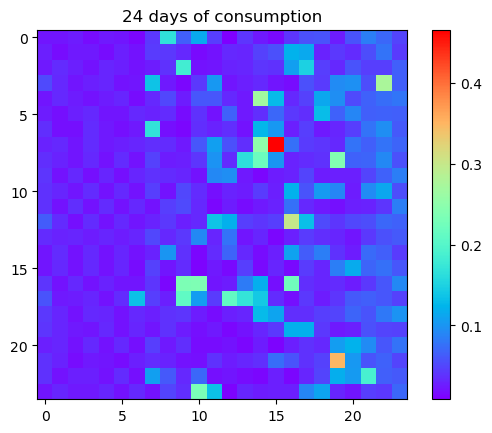

In [213]:
plt.imshow(cons_array_reshaped,cmap = 'rainbow')
plt.title("24 days of consumption")
plt.colorbar()

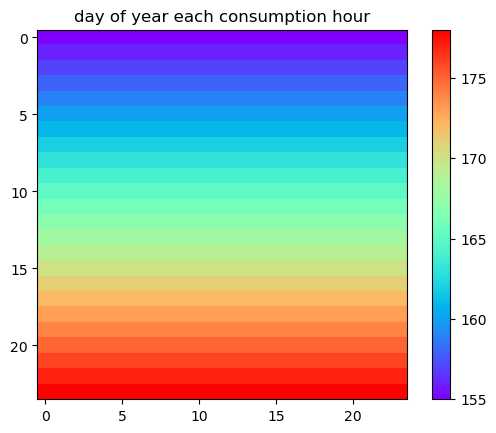

In [214]:
month_first_row = day_of_year_for_consumption_days_train.iloc[666].to_numpy()
month_img = month_first_row
for i in range (0,23):
    month_img = np.column_stack((month_img,month_first_row))


plt.imshow(month_img,cmap = 'rainbow')
plt.title("day of year each consumption hour")
plt.colorbar()

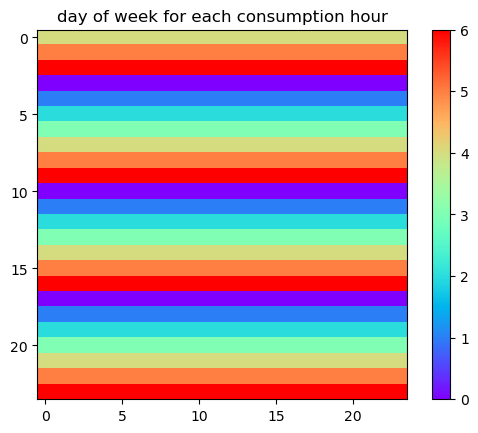

In [215]:
day_first_row = days_for_consumption_days_train.iloc[666].to_numpy()
day_img = day_first_row
for i in range (0,23):
    day_img = np.column_stack((day_img,day_first_row))


plt.imshow(day_img,cmap = 'rainbow')
plt.title("day of week for each consumption hour")
plt.colorbar()

### Generate numpy arrays for neural network

In [217]:
def save_method3_images(consumption_images, month_images, days_images, next_day_24_values):
    day_images_ = np.zeros((len(consumption_images), 24, 24))
    month_images_ = np.zeros((len(consumption_images), 24, 24))
    cons_images_ = np.zeros((len(consumption_images), 24, 24))
    
    next_day_24_values_normalized = next_day_24_values.apply(
    normalize_row,
    axis=1)


    next_day_24_values_ = np.zeros((len(consumption_images), 24))

    for row_id in range(0, len(consumption_images)):

        # days of week
        dow_row = days_images.iloc[row_id].to_numpy()
        dow_img = dow_row
        for i in range(0, 23):
            dow_img = np.column_stack((dow_img, dow_row))

        # months
        month_row = month_images.iloc[row_id].to_numpy()
        month_img = month_row
        for i in range(0, 23):
            month_img = np.column_stack((month_img, month_row))

        # cons
        cons_array = consumption_images.iloc[row_id].to_numpy()
        cons_array_reshaped = np.reshape(cons_array, (-1, 24))

        ### uncomment for noemalize month and day img
        #month_norm = pd.DataFrame(month_img).apply(normalize_doy,axis=1)
        #dow_norm = pd.DataFrame(day_img).apply(normalize_dow,axis=1)
        
        month_norm  = month_img
        dow_norm = dow_img

        # add each image in their corresponding array
        day_images_[row_id] = dow_norm
        month_images_[row_id] = month_norm
        cons_images_[row_id] = cons_array_reshaped

        #print (next_day_24_values[row_id])
        next_day_24_values_[row_id] = next_day_24_values_normalized.iloc[row_id]

        # plt.imshow(rgb)

    all_img_3_channels_ = np.concatenate((np.expand_dims(cons_images_, axis=3),
                                          np.expand_dims(month_images_, axis=3),
                                          np.expand_dims(day_images_, axis=3)), axis=3)
    return (all_img_3_channels_,next_day_24_values_)

### numpy arrays n-dimensionals for neural netwoks X (three channel images)

In [218]:
(all_img_3_channels_train,next_day_24_values_train) = save_method3_images(data_consumptions_train, day_of_year_for_consumption_days_train, days_for_consumption_days_train, data_consumptions_nexd_day_train)

In [219]:
(all_img_3_channels_val,next_day_24_values_val) = save_method3_images(data_consumptions_val, day_of_year_for_consumption_days_val, days_for_consumption_days_val, data_consumptions_nexd_day_val)

In [220]:
(all_img_3_channels_test,next_day_24_values_test) = save_method3_images(data_consumptions_test, day_of_year_for_consumption_days_test, days_for_consumption_days_test, data_consumptions_nexd_day_test)

In [221]:
all_img_3_channels_val.shape

(26280, 24, 24, 3)

In [222]:
all_img_3_channels_train.shape

(105120, 24, 24, 3)

In [223]:
all_img_3_channels_test.shape

(4960, 24, 24, 3)

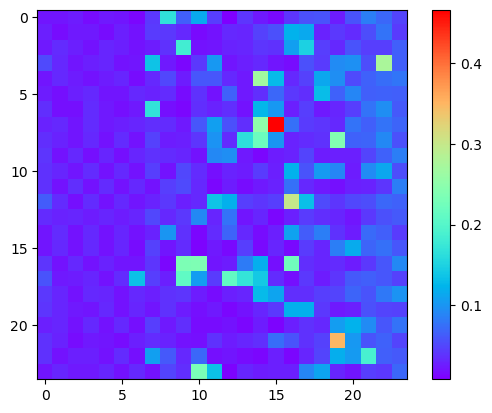

In [127]:
plt.imshow(all_img_3_channels_train[666,:,:,0],cmap = 'rainbow')
plt.colorbar()

## Train Deep Learning model

GPU setting

In [224]:
aux.set_gpu()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4878353505043862210
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 8106543994908889047
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1
]

Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


2024-05-26 13:35:21.879735: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-05-26 13:35:21.880545: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-05-26 13:35:21.880559: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-05-26 13:35:21.880908: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-26 13:35:21.881343: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Set tensor board control panel

In [225]:
from datetime import datetime
log_dir = "logs/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")

In [226]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)

In [227]:
%load_ext tensorboard

In [228]:
# Define the basic TensorBoard callback.
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')

2024-05-26 13:35:34.150194: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-26 13:35:34.150229: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Normalization of days of year and day of month images

In [229]:
def normalize_dow(x):
    normalized = (x - 0) / (6 - 0)
    return normalized

def normalize_doy(x):
    normalized = (x - 1) / (184 - 0)
    return normalized

In [230]:
vectorized_normalize_dow = np.vectorize(normalize_dow)
vectorized_normalize_doy = np.vectorize(normalize_doy)

all_img_3_channels_train[:,:,:,1] = vectorized_normalize_doy(all_img_3_channels_train[:,:,:,1])
all_img_3_channels_train[:,:,:,2] = vectorized_normalize_dow(all_img_3_channels_train[:,:,:,2])

In [231]:
all_img_3_channels_val[:,:,:,1] = vectorized_normalize_doy(all_img_3_channels_val[:,:,:,1])
all_img_3_channels_val[:,:,:,2] = vectorized_normalize_dow(all_img_3_channels_val[:,:,:,2])

In [232]:
all_img_3_channels_test[:,:,:,1] = vectorized_normalize_doy(all_img_3_channels_test[:,:,:,1])
all_img_3_channels_test[:,:,:,2] = vectorized_normalize_dow(all_img_3_channels_test[:,:,:,2])

### save data

In [233]:
np.save('../data/images_train.npy', all_img_3_channels_train) 
np.save('../data/labels_train.npy',next_day_24_values_train) 

np.save('../data/images_val.npy', all_img_3_channels_val) 
np.save('../data/labels_val.npy',next_day_24_values_val) 

np.save('../data/images_test.npy', all_img_3_channels_test) 
np.save('../data/labels_test.npy',next_day_24_values_test) 


### load data

In [4]:
all_img_3_channels_train = np.load('../data/images_train.npy') 
next_day_24_values_train = np.load('../data/labels_train.npy')

all_img_3_channels_val = np.load('../data/images_val.npy') 
next_day_24_values_val= np.load('../data/labels_val.npy')

all_img_3_channels_test = np.load('../data/images_test.npy') 
next_day_24_values_test = np.load('../data/labels_test.npy')

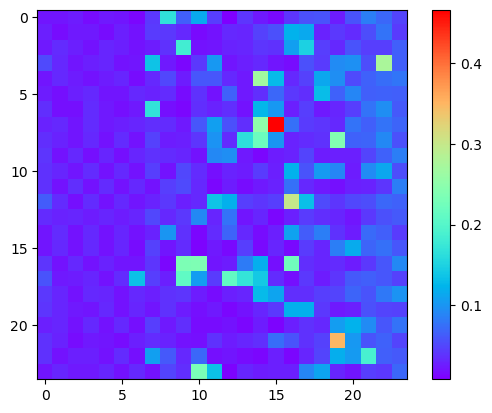

In [234]:
plt.imshow(all_img_3_channels_train[666,:,:,0],cmap='rainbow')
plt.colorbar()

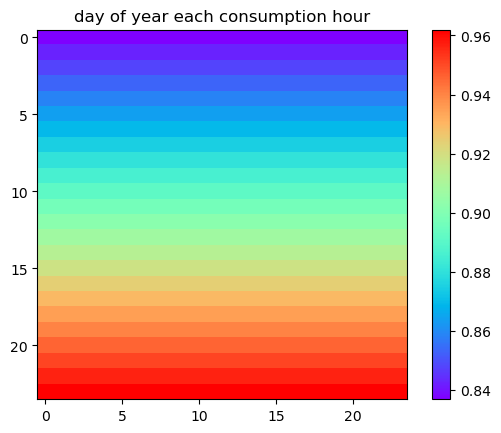

In [235]:
plt.imshow(all_img_3_channels_train[666,:,:,1],cmap='rainbow')
plt.title("day of year each consumption hour")
plt.colorbar()

### General model backbone 

In [237]:
import sklearn
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, Input, Rescaling
from sklearn.metrics import r2_score

def getModel():
    
    input_shape = (24,24,3)
    inputs = Input(input_shape)
    
    outputs = Conv2D(4, kernel_size=(9,9), activation='relu')(inputs)
    
    outputs = Conv2D(5, kernel_size=(5,5), activation='relu')(outputs)
    
    outputs = Conv2D(6, kernel_size=(5,5), activation='relu')(outputs)
    
    outputs = MaxPool2D()(outputs)
    
    outputs = Conv2D(7, kernel_size=(1,1), activation='relu')(outputs)
    
    outputs = MaxPool2D()(outputs)
    
    outputs = Conv2D(8, kernel_size=(1,1), activation='relu')(outputs)
    
    outputs = Flatten()(outputs)
    
    outputs = Dense(64, activation='relu')(outputs)
    outputs = Dense(32, activation='relu')(outputs)
    
    outputs = Dense(1)(outputs)
    
    model = tf.keras.Model(inputs, outputs)
    
    #compile model using accuracy to measure model performance
    model.compile(optimizer='adam', loss='mse', metrics=[r2_score,'mse','mae'], run_eagerly=True)
    
    return (model)

### Model backbone

In [238]:
getModel().summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 24, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 4)      │           976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 5)      │           505 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 6)        │           756 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 4, 4, 6)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 7)        │            49 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 2, 7)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 8)        │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,575 (25.68 KB)

 Trainable params: 6,575 (25.68 KB)

 Non-trainable params: 0 (0.00 B)

### Train 24 deep learning models for 24 next day hourly forecast 

In [239]:
%tensorboard --logdir logs/image
numModels = 24
models = []
for i in range(numModels): 
    # cargamos el backbone del modelo general sin guardar ningún peso para entrenar cada modelo (predecir cada hora)
    model = getModel()
    print(f"--------------Trainining model {i}")
    models.append(model.fit(all_img_3_channels_train, next_day_24_values_train[:,i], 
                     validation_data=(all_img_3_channels_val, next_day_24_values_val[:,i]),
                     epochs=10,
                     batch_size=1024,
                     callbacks=[[[tensorboard_callback]]]))
    model.save('cmodel_'+str(i)+'_h_general.keras')

--------------Trainining model 0
Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 24s 221ms/step - loss: 0.0028 - mae: 0.0354 - mse: 0.0028 - r2_score: -0.1302 - val_loss: 0.0022 - val_mae: 0.0292 - val_mse: 0.0022 - val_r2_score: -0.1672
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 24s 233ms/step - loss: 0.0020 - mae: 0.0287 - mse: 0.0020 - r2_score: 0.1996 - val_loss: 0.0020 - val_mae: 0.0270 - val_mse: 0.0020 - val_r2_score: -0.0229
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 22s 213ms/step - loss: 0.0019 - mae: 0.0277 - mse: 0.0019 - r2_score: 0.2449 - val_loss: 0.0019 - val_mae: 0.0287 - val_mse: 0.0019 - val_r2_score: -0.0790
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 21s 205ms/step - loss: 0.0019 - mae: 0.0267 - mse: 0.0019 - r2_score: 0.2734 - val_loss: 0.0018 - val_mae: 0.0281 - val_mse: 0.0018 - val_r2_score: -0.0490
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 21s 205ms/step - loss: 0.0017 - mae: 0.0259 - mse: 0.0017 - r2_score: 0.2934 - val_loss: 0.0017 - val_mae: 0.0258 - val_mse: 0.0017 - val_r2_s

### Save train and val history for 24 models

In [240]:

for i in range(0,24):
    np.save(f'../data/history_{i}.npy',models[i].history) 
    

### Plot error curves for 24 models

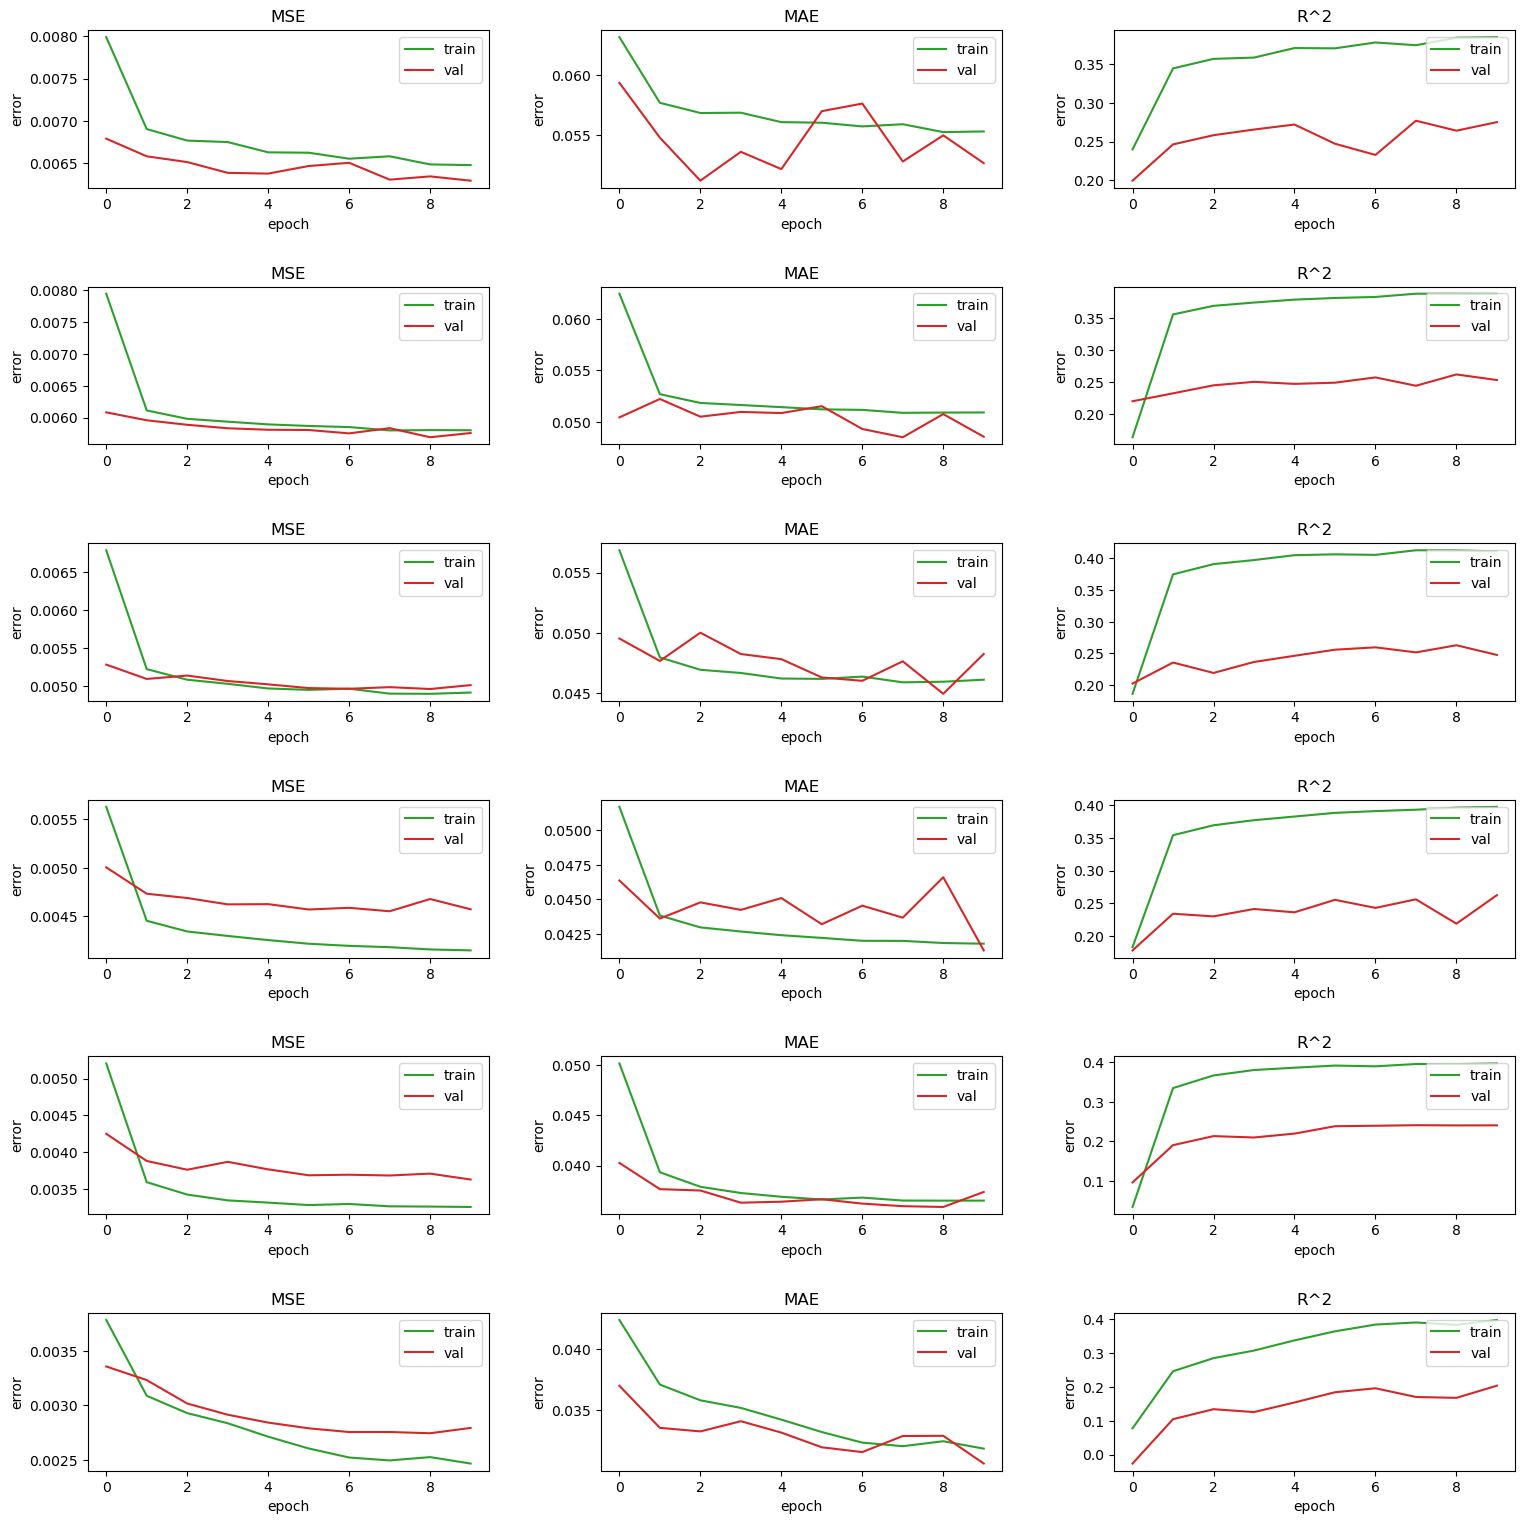

In [252]:
fig, axs = plt.subplots(6, 3,figsize=(15, 15))
fig.tight_layout(h_pad=5, w_pad=5)
model_start = 18
model_index = model_start
for i in range(0,6):
    for j in range(3):
        if j==0:
            axs[i, j].plot(models[model_index].history['mse'],'tab:green',label='train')
            axs[i, j].plot(models[model_index].history['val_mse'],'tab:red',label='val')
            axs[i, j].legend(loc="upper right")
            axs[i, j].set_title('MSE')
        elif j==1:
            axs[i, j].plot(models[model_index].history['mae'],'tab:green',label='train')
            axs[i, j].plot(models[model_index].history['val_mae'],'tab:red',label='val')
            axs[i, j].set_title('MAE')
            axs[i, j].legend(loc="upper right")
        else:
             axs[i, j].plot(models[model_index].history['r2_score'],'tab:green',label='train')
             axs[i, j].plot(models[model_index].history['val_r2_score'],'tab:red',label='val')
             axs[i, j].legend(loc="upper right")
             axs[i, j].set_title('R^2')
    model_index+=1

for ax in axs.flat:
    ax.set(xlabel='epoch', ylabel='error')
            


### Load 24 model DL

In [255]:
import keras
models = []
for i in range(numModels): 
    model = tf.keras.models.load_model('../models/cmodel_'+str(i)+'_h_general.keras',custom_objects={"r2_score": r2_score})
    models.append(model)

### Predicions over test

In [256]:
 ## de-normalizar
#max_val = 14986
#min_val = 1

def unnormalize_row(x):
    unnormalized = x * (max_val - min_val) + min_val
    return unnormalized



### Predictions over test set with each of 24 model


In [275]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

### Para cada modelo, realizamos la predicción sobre el conjunto de test
mse = []
mae = []

for i in range(numModels):
    
    model = models[i]
    test_predictions = model.predict(all_img_3_channels_test)

    test_predictions_unnormalized = pd.DataFrame(test_predictions).apply(
        unnormalize_row,
        axis=1)
    
    real_values_unnormalized = pd.DataFrame(next_day_24_values_test[:,i]).apply(
        unnormalize_row,
        axis=1)
    
    mse.append(mean_squared_error(real_values_unnormalized,test_predictions_unnormalized))
    mae.append(mean_absolute_error(real_values_unnormalized,test_predictions_unnormalized))


155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


### Predictions over test set with 24 persistent models

In [259]:
data_consumptions_test_for_persistent = data_consumptions_test.iloc[:, 0:24]

# Create  dataset for persistent (one for each of 24 hour)
df_array_test = []
for i in range (0,24):
    values = pd.DataFrame(data_consumptions_test_for_persistent.iloc[:, i].values)
    dataframe = pd.concat([values.shift(1), values], axis=1)
    dataframe.columns = ['t-1', 't+1']
    dataframe = dataframe.iloc[1: , :]
    df_array_test.append(dataframe)
    
mae_arima = []
mse_arima = []
for i in range(24):
    test_predictions_unnormalized = pd.DataFrame(df_array_test[i].iloc[:,1]).apply(
        unnormalize_row,
        axis=1)
    
    real_values_unnormalized = pd.DataFrame(df_array_test[i].iloc[:,0]).apply(
        unnormalize_row,
        axis=1)
    mse_arima.append(mean_squared_error(test_predictions_unnormalized,real_values_unnormalized ))
    mae_arima.append(mean_absolute_error(test_predictions_unnormalized, real_values_unnormalized))




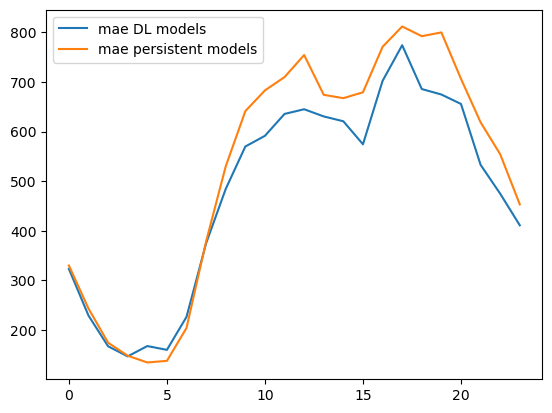

In [260]:
x_axis = range(0,24)
plt.plot(x_axis, mae, label = "mae DL models") 
plt.plot(x_axis, mae_arima, label = "mae persistent models") 
#plt.plot(x_axis, mse, label = "mse DL models") 
plt.legend() 
plt.show()

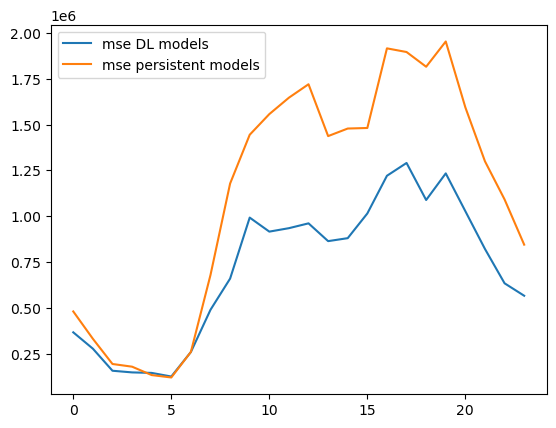

In [261]:
x_axis = range(0,24)
plt.plot(x_axis, mse, label = "mse DL models") 
plt.plot(x_axis, mse_arima, label = "mse persistent models") 
plt.legend() 
plt.show()

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Text(0, 0.5, 'normalized Wh')

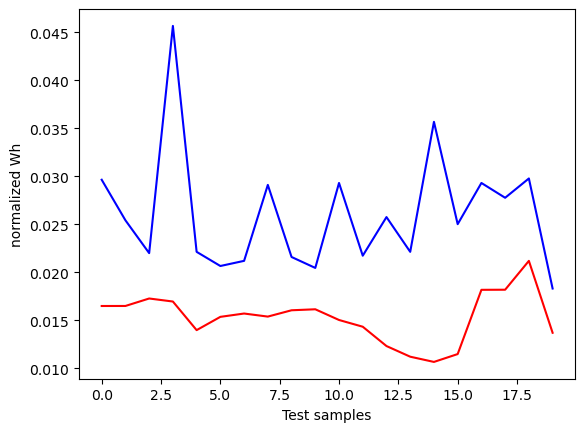

In [272]:
hour_train = 3

model = models[hour_train]
test_predictions = model.predict(all_img_3_channels_test)

test_predictions_unnormalized = pd.DataFrame(test_predictions).apply(
    unnormalize_row,
    axis=1)

real_values_unnormalized = pd.DataFrame(next_day_24_values_test[:,hour_train]).apply(
    unnormalize_row,
    axis=1)

plt.plot(next_day_24_values_test[:,hour_train][0:20],color="blue")
plt.plot(test_predictions[0:20],color="red")
plt.xlabel("Test samples")
plt.ylabel("normalized Wh")

In [265]:
### persistente a las 21
test_predictions_unnormalized = pd.DataFrame(df_array_test[21].iloc[:,1]).apply(
    unnormalize_row,
    axis=1)

real_values_unnormalized = pd.DataFrame(df_array_test[21].iloc[:,0]).apply(
    unnormalize_row,
    axis=1)

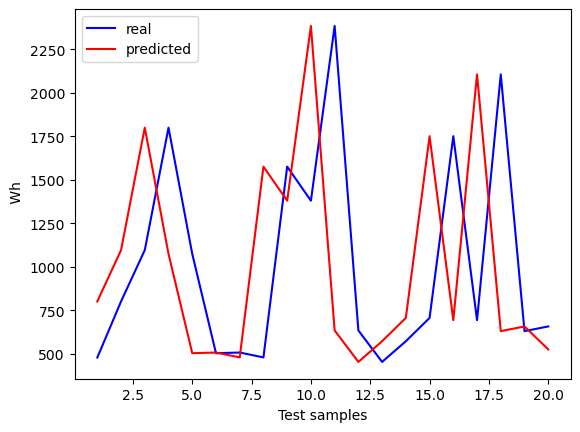

In [268]:
plt.plot(real_values_unnormalized[0:20],color="blue", label="real")
plt.plot(test_predictions_unnormalized[0:20],color="red", label="predicted")
plt.legend(loc="upper left")
plt.xlabel("Test samples")
plt.ylabel(" Wh")
plt.show()

In [341]:
real_values_unnormalized

,0
0,523.0
1,696.0
2,499.0
3,519.0
4,600.0
...,...
4955,535.0
4956,1374.0
4957,4437.0
4958,536.0


In [342]:
test_predictions_unnormalized

,0
0,1582.139038
1,1707.053711
2,1805.177246
3,1590.669189
4,1649.733032
...,...
4955,2271.695557
4956,2458.161377
4957,2396.071777
4958,2482.507080


In [74]:
from sklearn.metrics import mean_squared_error
mean_squared_error(real_values_unnormalized,test_predictions_unnormalized)


1080616.4864575057

In [63]:
score = model.evaluate(all_img_3_channels_test,  next_day_24_values_test[:,20], verbose = 0) 

print('Test loss:', score[0]) 

Test loss: 0.0048123616725206375


### with images rgb 3 channels

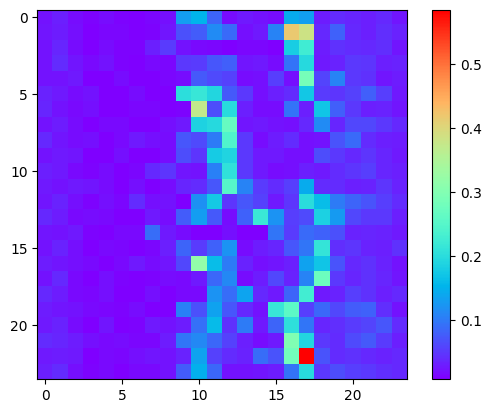

In [112]:
plt.imshow(all_img_3_channels_train[0,:,:,0],cmap='rainbow')
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


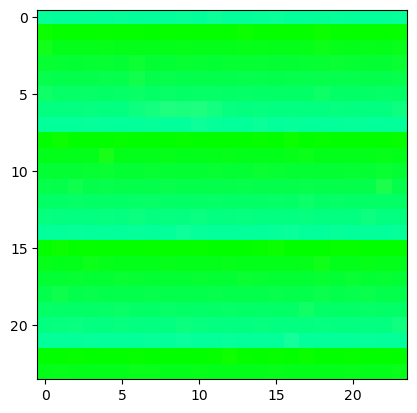

In [129]:
r = all_img_3_channels_train[0,:,:,0]
g = all_img_3_channels_train[0,:,:,1]
b = all_img_3_channels_train[0,:,:,2]
rgb = np.dstack((r, g, b))
plt.imshow(rgb,cmap='rainbow')

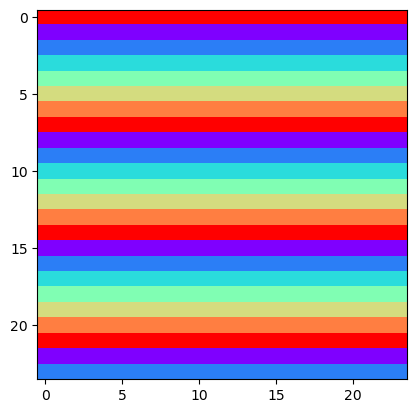

In [128]:
plt.imshow(all_img_3_channels_train[0,:,:,2],cmap='rainbow')

In [113]:
all_img_3_channels_train

array([[[[0.02229937, 0.5       , 0.1       ],
         [0.03151289, 0.5       , 0.1       ],
         [0.01849379, 0.5       , 0.1       ],
         ...,
         [0.03164641, 0.5       , 0.1       ],
         [0.03892375, 0.5       , 0.1       ],
         [0.02523701, 0.5       , 0.1       ]],

        [[0.02503672, 0.5       , 0.2       ],
         [0.02944318, 0.5       , 0.2       ],
         [0.01969555, 0.5       , 0.2       ],
         ...,
         [0.03184671, 0.5       , 0.2       ],
         [0.04206169, 0.5       , 0.2       ],
         [0.03244759, 0.5       , 0.2       ]],

        [[0.02229937, 0.5       , 0.3       ],
         [0.03478435, 0.5       , 0.3       ],
         [0.01709173, 0.5       , 0.3       ],
         ...,
         [0.03792229, 0.5       , 0.3       ],
         [0.04346375, 0.5       , 0.3       ],
         [0.02483643, 0.5       , 0.3       ]],

        ...,

        [[0.03945787, 0.5       , 0.1       ],
         [0.03498464, 0.5       , 0.1       ]

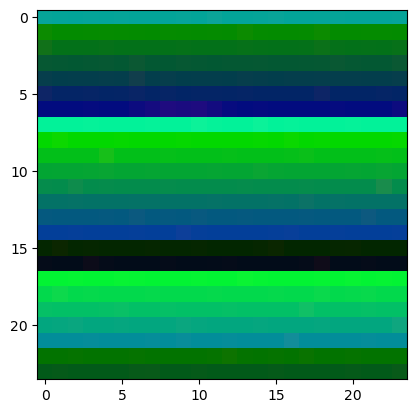

In [143]:
rgb_img = np.dstack((all_img_3_channels_train[0,:,:,0], all_img_3_channels_train[0,:,:,1], all_img_3_channels_train[0,:,:,2]))
#plt.imshow(rgb_img,cmap='rainbow')
plt.imshow((rgb_img * 255).astype(np.uint8))

In [145]:
rgb_img*255

array([[[6.36436436e+00, 3.74850000e+03, 1.53000000e+02],
        [3.98198198e+00, 3.74850000e+03, 1.53000000e+02],
        [2.92692693e+00, 3.74850000e+03, 1.53000000e+02],
        ...,
        [3.96496496e+00, 3.74850000e+03, 1.53000000e+02],
        [3.72672673e+00, 3.74850000e+03, 1.53000000e+02],
        [5.64964965e+00, 3.74850000e+03, 1.53000000e+02]],

       [[1.24564565e+01, 3.72300000e+03, 0.00000000e+00],
        [3.35235235e+00, 3.72300000e+03, 0.00000000e+00],
        [3.60760761e+00, 3.72300000e+03, 0.00000000e+00],
        ...,
        [4.08408408e+00, 3.72300000e+03, 0.00000000e+00],
        [4.05005005e+00, 3.72300000e+03, 0.00000000e+00],
        [3.18218218e+00, 3.72300000e+03, 0.00000000e+00]],

       [[1.79359359e+01, 3.69750000e+03, 2.55000000e+01],
        [3.96496496e+00, 3.69750000e+03, 2.55000000e+01],
        [3.59059059e+00, 3.69750000e+03, 2.55000000e+01],
        ...,
        [4.06706707e+00, 3.69750000e+03, 2.55000000e+01],
        [3.94794795e+00, 3.69

In [105]:
all_img_3_channels_train[0,:,:,0]

array([[0.02229937, 0.03151289, 0.01849379, 0.0105488 , 0.01849379,
        0.01008145, 0.00874616, 0.01301909, 0.01969555, 0.13092536,
        0.15262385, 0.08278809, 0.01815997, 0.02617172, 0.02236614,
        0.01662438, 0.14354386, 0.13239418, 0.02824142, 0.04085993,
        0.03611964, 0.03164641, 0.03892375, 0.02523701],
       [0.02503672, 0.02944318, 0.01969555, 0.00741087, 0.01361998,
        0.01382027, 0.00741087, 0.01161704, 0.02370143, 0.06623047,
        0.07611163, 0.11370009, 0.0867272 , 0.01929497, 0.0267726 ,
        0.10689011, 0.41821338, 0.38382962, 0.03785552, 0.0814528 ,
        0.03672052, 0.03184671, 0.04206169, 0.03244759],
       [0.02229937, 0.03478435, 0.01709173, 0.00761116, 0.01729203,
        0.01041528, 0.01041528, 0.03024436, 0.05174256, 0.02256643,
        0.01542262, 0.01215116, 0.0075444 , 0.01408733, 0.01355321,
        0.00854587, 0.18126586, 0.2258646 , 0.02810789, 0.04519963,
        0.04112699, 0.03792229, 0.04346375, 0.02483643],
       [0.022

- Prepara labels for image rgb methodology

- Save images on folder train test and val

In [109]:
### Save images
import matplotlib.image as img

for row_id in range(0, len(all_img_3_channels_train)):
    r = all_img_3_channels_train[row_id,:,:,0]
    g = all_img_3_channels_train[row_id,:,:,1]
    b = all_img_3_channels_train[row_id,:,:,2]
    rgb = np.dstack((r, g, b))
    img.imsave(f'../data/images/input/train/{row_id}.png', rgb, cmap="rainbow")
    
for row_id in range(0, len(all_img_3_channels_val)):
    r = all_img_3_channels_val[row_id,:,:,0]
    g = all_img_3_channels_val[row_id,:,:,1]
    b = all_img_3_channels_val[row_id,:,:,2]
    rgb = np.dstack((r, g, b))
    img.imsave(f'../data/images/input/val/{row_id}.png', rgb, cmap="rainbow")
    
for row_id in range(0, len(all_img_3_channels_test)):
    r = all_img_3_channels_test[row_id,:,:,0]
    g = all_img_3_channels_test[row_id,:,:,1]
    b = all_img_3_channels_test[row_id,:,:,2]
    rgb = np.dstack((r, g, b))
    img.imsave(f'../data/images/input/test/{row_id}.png', rgb, cmap="rainbow")
    


In [180]:
r = all_img_3_channels_train[0,:,:,0]
g = all_img_3_channels_train[0,:,:,1]
b = all_img_3_channels_train[0,:,:,2]
rgb = np.dstack((r, g, b))
img.imsave(f'../data/images/bla.png', rgb, cmap="rainbow")

ValueError: Floating point image RGB values must be in the 0..1 range.

In [187]:
all_img_3_channels_train[0,:,:,1]

array([[14.7, 14.7, 14.7, 14.7, 14.7, 14.7, 14.7, 14.7, 14.7, 14.7, 14.7,
        14.7, 14.7, 14.7, 14.7, 14.7, 14.7, 14.7, 14.7, 14.7, 14.7, 14.7,
        14.7, 14.7],
       [14.6, 14.6, 14.6, 14.6, 14.6, 14.6, 14.6, 14.6, 14.6, 14.6, 14.6,
        14.6, 14.6, 14.6, 14.6, 14.6, 14.6, 14.6, 14.6, 14.6, 14.6, 14.6,
        14.6, 14.6],
       [14.5, 14.5, 14.5, 14.5, 14.5, 14.5, 14.5, 14.5, 14.5, 14.5, 14.5,
        14.5, 14.5, 14.5, 14.5, 14.5, 14.5, 14.5, 14.5, 14.5, 14.5, 14.5,
        14.5, 14.5],
       [14.4, 14.4, 14.4, 14.4, 14.4, 14.4, 14.4, 14.4, 14.4, 14.4, 14.4,
        14.4, 14.4, 14.4, 14.4, 14.4, 14.4, 14.4, 14.4, 14.4, 14.4, 14.4,
        14.4, 14.4],
       [14.3, 14.3, 14.3, 14.3, 14.3, 14.3, 14.3, 14.3, 14.3, 14.3, 14.3,
        14.3, 14.3, 14.3, 14.3, 14.3, 14.3, 14.3, 14.3, 14.3, 14.3, 14.3,
        14.3, 14.3],
       [14.2, 14.2, 14.2, 14.2, 14.2, 14.2, 14.2, 14.2, 14.2, 14.2, 14.2,
        14.2, 14.2, 14.2, 14.2, 14.2, 14.2, 14.2, 14.2, 14.2, 14.2, 14.2,
       

In [183]:
b

array([[0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
        0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
        0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
        0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
       [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
        0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3],
       [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
        0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6

- Prepara labels

In [4]:
img_ids =  [*range(0,len(next_day_24_values_train))]
img_ids =  np.char.mod('%d', img_ids)
labels = next_day_24_values_train[:,13]
names = ["id","score"]

train_label_df = pd.DataFrame(
    {'id': img_ids,
     'score': labels,
    })
train_label_df


,id,score
0,0,0.071772
1,1,0.044198
2,2,0.023835
3,3,0.148952
4,4,0.027841
...,...,...
99008,99008,0.111897
99009,99009,0.134664
99010,99010,0.009547
99011,99011,0.005809


In [5]:
img_ids = [*range(0,len(next_day_24_values_val))]
img_ids =  np.char.mod('%d', img_ids)
labels = next_day_24_values_val[:,13]
names = ["id","score"]

val_label_df = pd.DataFrame(
    {'id': img_ids,
     'score': labels,
    })
val_label_df

,id,score
0,0,0.025103
1,1,0.019629
2,2,0.021431
3,3,0.100347
4,4,0.032514
...,...,...
24590,24590,0.037255
24591,24591,0.044999
24592,24592,0.021164
24593,24593,0.041728


In [6]:
val_label_df['id'] = val_label_df['id'].astype(str) + '.png'
train_label_df['id'] = train_label_df['id'].astype(str) + '.png'

In [259]:
val_label_df['score'] = val_label_df['score'].astype('float')
train_label_df['score'] = train_label_df['score'].astype('float')

In [251]:
train_label_df

,id,score
0,0.png,0.071772
1,1.png,0.044198
2,2.png,0.023835
3,3.png,0.148952
4,4.png,0.027841
...,...,...
99008,99008.png,0.111897
99009,99009.png,0.134664
99010,99010.png,0.009547
99011,99011.png,0.005809


In [9]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(
#       rescale=1./255,
#       rotation_range=40,
#       width_shift_range=0.2,
      # height_shift_range=0.2,
      # shear_range=0.2,
      # zoom_range=0.2,
      # horizontal_flip=True,
      # fill_mode='nearest')
      

train_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)


train_generator_ = train_datagen.flow_from_dataframe(
    dataframe=train_label_df,
    directory='../data/images/train/train',
    x_col="id",
    y_col="score",
    color_mode="rgb",
    class_mode="other", 
    target_size=(24, 24),
    batch_size=32
)

valid_generator_ = val_datagen.flow_from_dataframe(
    dataframe=val_label_df,
    directory='../data/images/val/val',
    x_col="id",
    y_col="score",
    class_mode="other", 
    color_mode="rgb",
    target_size=(24, 24),
    batch_size=32
)



Found 99013 validated image filenames.
Found 24483 validated image filenames.


/Users/fran/venv-tfmetal/lib/python3.9/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 112 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


In [27]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, Input, Rescaling


input_shape = (24,24,3)
inputs = Input(input_shape)

## DA
#model.add(dl.data_augmentation)
###

model = tf.keras.Sequential()
model.add(inputs)
model.add (Conv2D(4, kernel_size=(9,9), activation='relu'))
model.add (Conv2D(5, kernel_size=(5,5), activation='relu'))
model.add (Conv2D(6, kernel_size=(5,5), activation='relu'))
model.add (MaxPool2D())
model.add (Conv2D(7, kernel_size=(1,1), activation='relu'))
model.add (MaxPool2D())
model.add (Conv2D(8, kernel_size=(1,1), activation='relu'))
model.add (Flatten())
model.add (Dense(128))
model.add (Dense(64))
model.add (Dense(1))

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['r2_score'])

In [29]:

%tensorboard --logdir logs/image

hist = model.fit(
    x = train_generator_, 
    validation_data = valid_generator_,
    epochs=10,
    batch_size=32,
    callbacks=[[[tensorboard_callback]]]
)

Reusing TensorBoard on port 6006 (pid 12528), started 0:14:58 ago. (Use '!kill 12528' to kill it.)

Epoch 1/10


2024-05-09 16:21:35.253062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/fran/venv-tfmetal/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-09 16:22:08.399536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 1 of 8
2024-05-09 16:22:47.359113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 2 of 8
2024-05-09 16:23:10.625951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer 

AttributeError: 'NoneType' object has no attribute 'items'

In [327]:
model.summary()

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 24, 24, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 22, 22, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │       495,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,492,613 (5.69 MB)

 Trainable params: 497,537 (1.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 995,076 (3.80 MB)

In [378]:
model.save('cmodel_20_h_general.keras')